# Спортивный анализ данных. Платформа Kaggle

## Урок 7. Тюнинг гиперпараметров, построение ансамблей алгоритмов.

### Домашнее задание:

Чтобы было больше времени на выполнение курсовой работы, задание выполнить на __наборе данных для соревнования__:

__Тестовая выборка__ - это выборка для применения модели и загрузки на ЛБ.

**[Задание 1](#task1):**
Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

**[Задание 2](#task2):**
Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

**[Задание 3](#task3):**
Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.
Выполнить задание 2 для трех моделей.

**[Задание 4](#task4):**
(опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

**[Задание 5](#task5):**
(опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [1]:
import pandas as pd 
import numpy as np
# Модель
import xgboost as xgb

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

In [2]:
def reduce_mem_usage(df):
    '''Сокращение размера датафрейма за счёт изменения типа данных'''
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
TRAIN_DATASET_PATH = '../../data/train.csv'
TEST_DATASET_PATH = '../../data/test.csv'
BKI_DATASET_PATH = '../../data/bki.csv'
applications_history_DATASET_PATH = '../../data/applications_history.csv'
client_profile_DATASET_PATH = '../../data/client_profile.csv'
payments_DATASET_PATH = '../../data/payments.csv'
sample_submit_DATASET_PATH = '../../data/sample_submit.csv'

ID_COLUMN = 'APPLICATION_NUMBER'
ID_COLUMN_PR = 'PREV_APPLICATION_NUMBER'
TARGET = 'TARGET'

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
df_train =reduce_mem_usage(train)  # Уменьшаем размер данных
#df_train.info()


test = pd.read_csv(TEST_DATASET_PATH)
df_test =reduce_mem_usage(test)  # Уменьшаем размер данных

bki = pd.read_csv(BKI_DATASET_PATH)
df_bki =reduce_mem_usage(bki)  # Уменьшаем размер данных
#df_bki.info()

client_profile = pd.read_csv(client_profile_DATASET_PATH)
df_client_profile =reduce_mem_usage(client_profile)  # Уменьшаем размер данных
#df_client_profile.info()

payments = pd.read_csv(payments_DATASET_PATH)
df_payments =reduce_mem_usage(payments)  # Уменьшаем размер данных
#df_payments.info()

applications_history = pd.read_csv(applications_history_DATASET_PATH)
df_applications_history =reduce_mem_usage(applications_history)  # Уменьшаем размер данных
#df_applications_history.info()

Memory usage of dataframe is 2.52 MB
Memory usage after optimization is: 0.63 MB
Decreased by 75.0%
Memory usage of dataframe is 2.52 MB
Memory usage after optimization is: 0.79 MB
Decreased by 68.7%
Memory usage of dataframe is 122.60 MB
Memory usage after optimization is: 48.68 MB
Decreased by 60.3%
Memory usage of dataframe is 45.78 MB
Memory usage after optimization is: 18.12 MB
Decreased by 60.4%
Memory usage of dataframe is 62.50 MB
Memory usage after optimization is: 29.30 MB
Decreased by 53.1%
Memory usage of dataframe is 331.31 MB
Memory usage after optimization is: 114.69 MB
Decreased by 65.4%


In [5]:
df_train['TARGET'].value_counts()  # Количество различных значений признака 'TARGET'

0    101196
1      8897
Name: TARGET, dtype: int64

In [6]:
train_df = df_train.merge(bki, on=ID_COLUMN, how='left')
train_df = train_df.merge(client_profile, on=ID_COLUMN, how='left')
train_df = train_df.merge(bki, on=ID_COLUMN, how='left')

In [7]:
test_df = df_test.merge(bki, on=ID_COLUMN, how='left')
test_df = test_df.merge(client_profile, on=ID_COLUMN, how='left')
test_df = test_df.merge(bki, on=ID_COLUMN, how='left')
#test_df.info()

In [8]:
train_df.set_index('APPLICATION_NUMBER', inplace=True)

In [9]:
X = train_df.drop('TARGET', axis=1)#.fillna(-1)
y = train_df['TARGET']

In [10]:
numerical_features = train_df.select_dtypes(exclude=["category"])
numerical_features = numerical_features.columns.tolist()
#numerical_features.remove('APPLICATION_NUMBER')
numerical_features.remove('TARGET')

In [11]:
ids = test_df['APPLICATION_NUMBER'].values
test_df.set_index('APPLICATION_NUMBER', inplace=True)
X_test = test_df[numerical_features]

In [12]:
x_train, x_test = train_test_split(
    X, train_size=0.75, random_state=27
)
y_train, y_test = train_test_split(
    y, train_size=0.75, random_state=27
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 1214461 rows, 56 cols
x_test.shape = 404821 rows, 56 cols


## Задание 1:<a class="anchor" id="task1"></a>

 Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

***OOF — out of folds***, техника получения предсказаний модели для тренировочной части датасета используя кросс-валидацию. Незаменима для дальнейшей сборки нескольких решений в ансамбль.

### XGBoost

In [13]:
# Модель
import xgboost as xgb
# Метрика
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

In [14]:
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "n_estimators": 2000,  # количество деревьев
    #"n_estimators": 250,
    "learning_rate": 0.1,
    "reg_lambda": 10,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [15]:
eval_sets= [
    (x_train[numerical_features], y_train),
    (x_test[numerical_features], y_test)
]

In [16]:
xgb_model = xgb.XGBClassifier(**xgb_params)

xgb_model.fit(
    y=y_train,
    X=x_train[numerical_features],
    early_stopping_rounds=50,
    eval_set=eval_sets,
    eval_metric="auc",
    verbose=10
)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.68473	validation_1-auc:0.68488
[10]	validation_0-auc:0.72499	validation_1-auc:0.72449
[20]	validation_0-auc:0.73940	validation_1-auc:0.73864
[30]	validation_0-auc:0.75032	validation_1-auc:0.74948
[40]	validation_0-auc:0.76294	validation_1-auc:0.76161
[50]	validation_0-auc:0.77358	validation_1-auc:0.77216
[60]	validation_0-auc:0.78203	validation_1-auc:0.78092
[70]	validation_0-auc:0.78772	validation_1-auc:0.78683
[80]	validation_0-auc:0.79132	validation_1-auc:0.79030
[90]	validation_0-auc:0.79683	validation_1-auc:0.79575
[100]	validation_0-auc:0.80106	validation_1-auc:0.79998
[110]	validation_0-auc:0.80515	validation_1-auc:0.80405
[120]	validation_0-auc:0.80891	validation_1-auc:0.80754
[130]	validation_0-auc:0.81325	validation_1-auc:0.81174
[140]	validation_0-auc:0.81732	validation_1-auc:0.81571
[150]	validation_0-auc:0.82085	validation_1-auc:0.81921
[160]	validation_0-auc:0.82336	validation_1-auc:0.82169
[170]	validation_0-auc:0.82557	validation_1-auc:0.82375
[18

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=2000, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

    [920]	validation_0-auc:0.91448	validation_1-auc:0.90886

In [ ]:
y_pred_train_xgb = xgb_model.predict(train_df[numerical_features])

In [19]:
# make predictions for test data (Тестовая выборка)
# x = X_test.values
y_pred_xgb = xgb_model.predict(X_test)
output_xgb = pd.DataFrame({'APPLICATION_NUMBER': ids, 'TARGET': y_pred_xgb})

In [20]:
output_xgb.tail(10)

,APPLICATION_NUMBER,TARGET
2436793,123433260,0
2436794,123433260,0
2436795,123433260,0
2436796,123433260,0
2436797,123433260,0
2436798,123433260,0
2436799,123433260,0
2436800,123433260,0
2436801,123433260,0
2436802,123433260,0


In [21]:
output_xgb['TARGET'].value_counts()  # Количество различных значений признака 'TARGET'

0    2421344
1      15459
Name: TARGET, dtype: int64

### Оценка качества модели

In [23]:
train_score = roc_auc_score(y_train, xgb_model.predict(x_train[numerical_features]))
test_score = roc_auc_score(y_test, xgb_model.predict(x_test[numerical_features]))

print(f'train_score={train_score}')
print(f'test_score={test_score}')

train_score=0.6694041054483558
test_score=0.6671894975645648


### LightGBM Sklearn-API

In [24]:
import lightgbm as lgb

In [28]:
# Задача бинарной классификации
lgb_params = {
    "boosting_type": "gbdt",  # gradient boosting tree decision tree (бустинг над решающими деревьями)
    "objective": "binary",
    "metric": "auc", # метрика качества - ROC AUC
    #"learning_rate": 0.01,  # скорость обучения
    "learning_rate": 0.1,  # скорость обучения
    # "n_estimators": 20000,  # число деревьев
    "n_estimators": 10000,  # число деревьев
    #"n_estimators": 250,
     # регуляризация
    "reg_lambda": 100,  # регуляризация (то что используется при F2-штрафе (1:15:10))
    "max_depth": 4,  # глубина дерева
    #"gamma": 10,  # min-е улучшение функции потерь при котором мы будем делать разбиени (1:15:40)
    #"nthread": 6, # число ядер
    "n_jobs": 6,
    "seed": 27
}

In [29]:
# Оценить качество модели на валидационной выборке, оценить расхождение
# по сравнению с качеством на обучающей выборке и валидационной выборке.
model_lgb = lgb.LGBMClassifier(**lgb_params)
model_lgb.fit(
    X=x_train[numerical_features],
    y=y_train,
    eval_set=[(x_train[numerical_features], y_train), (x_test[numerical_features], y_test)],
    #categorical_feature = catigorical_features_name,
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=500
)

Training until validation scores don't improve for 25 rounds
[500]	valid_0's auc: 0.869603	valid_1's auc: 0.865265
[1000]	valid_0's auc: 0.903491	valid_1's auc: 0.897719
[1500]	valid_0's auc: 0.925507	valid_1's auc: 0.919065
[2000]	valid_0's auc: 0.938472	valid_1's auc: 0.931507
[2500]	valid_0's auc: 0.948264	valid_1's auc: 0.941072
[3000]	valid_0's auc: 0.955083	valid_1's auc: 0.947619
[3500]	valid_0's auc: 0.960691	valid_1's auc: 0.953151
[4000]	valid_0's auc: 0.965539	valid_1's auc: 0.95776
[4500]	valid_0's auc: 0.969229	valid_1's auc: 0.961325
[5000]	valid_0's auc: 0.972071	valid_1's auc: 0.964034
[5500]	valid_0's auc: 0.974708	valid_1's auc: 0.966659
[6000]	valid_0's auc: 0.977071	valid_1's auc: 0.96911
[6500]	valid_0's auc: 0.979196	valid_1's auc: 0.971297
[7000]	valid_0's auc: 0.9808	valid_1's auc: 0.972898
[7500]	valid_0's auc: 0.982253	valid_1's auc: 0.974398
[8000]	valid_0's auc: 0.983597	valid_1's auc: 0.975818
[8500]	valid_0's auc: 0.98494	valid_1's auc: 0.977109
[9000]	val

LGBMClassifier(max_depth=4, metric='auc', n_estimators=10000, n_jobs=6,
               objective='binary', reg_lambda=100, seed=27)

    [10000]	valid_0's auc: 0.987944	valid_1's auc: 0.980112

In [ ]:
y_pred_train_lgb = model_lgb.predict(train_df[numerical_features])

In [31]:
# make predictions for test data  (Тестовая выборка)
#ids = test_df['APPLICATION_NUMBER'].values
x = X_test[numerical_features].values
y_pred_lgb = model_lgb.predict(x)
output_lgb = pd.DataFrame({'APPLICATION_NUMBER': ids, 'TARGET': y_pred_lgb})

In [32]:
output_lgb.head(10)

,APPLICATION_NUMBER,TARGET
0,123724268,0
1,123456549,1
2,123456549,1
3,123456549,1
4,123456549,1
5,123428178,0
6,123428178,0
7,123428178,0
8,123428178,0
9,123428178,0


In [33]:
output_lgb['TARGET'].value_counts()  # Количество различных значений признака 'TARGET'

0    2401692
1      35111
Name: TARGET, dtype: int64

### Оценка качества модели

In [35]:
train_score = roc_auc_score(y_train, model_lgb.predict(x_train[numerical_features]))
test_score = roc_auc_score(y_test, model_lgb.predict(x_test[numerical_features]))

print(f'train_score={train_score}')
print(f'test_score={test_score}')

train_score=0.8688907741973214
test_score=0.8552374766749109


### Prediction Correlation

__Корреляция на тренировочной выборке__

In [ ]:
# 2. Визуализация
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# scores = pd.DataFrame({
#     'lgbm_numerical': model_lgb.predict(x_train[numerical_features]),
#     'xgb_numerical': xgb_model.predict(x_train[numerical_features])
# })


# y_pred_train_lgb = model_lgb.predict(train_df[numerical_features]
# y_pred_train_xgb = xgb_model.predict(train_df[numerical_features])
# scores = pd.DataFrame({
#     'lgbm_numerical': model_lgb.predict(train_df[numerical_features]),
#     'xgb_numerical': xgb_model.predict(train_df[numerical_features])
# })

scores = pd.DataFrame({
    'lgbm_numerical': y_pred_train_lgb,
    'xgb_numerical': y_pred_train_xgb
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

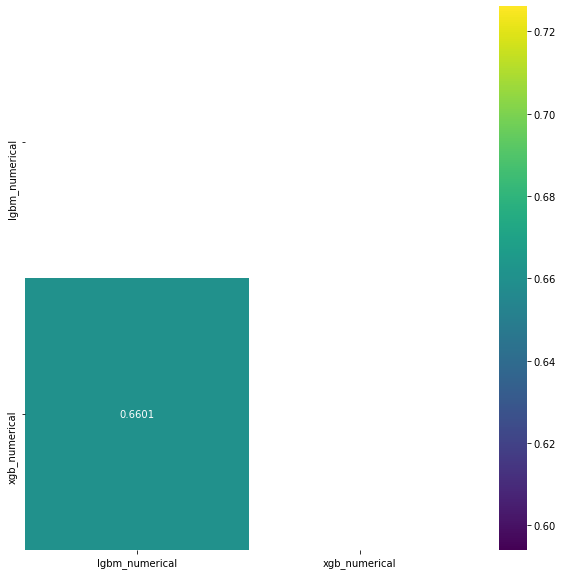

In [39]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4f", cmap="viridis", ax=axes)

__Корреляция на тестовой выборке__

<AxesSubplot:>

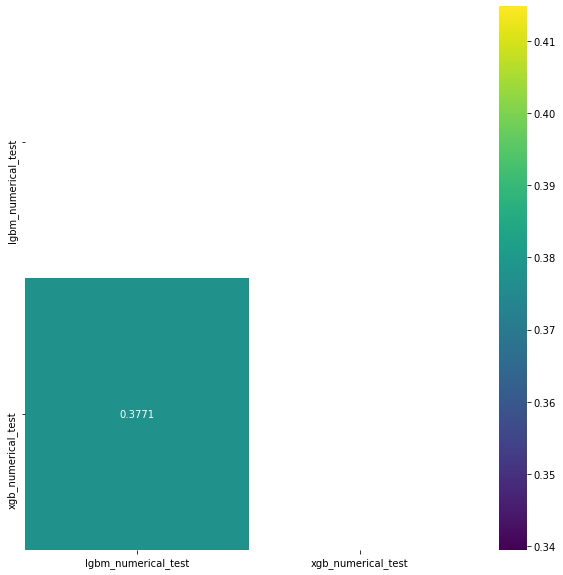

In [40]:
scores = pd.DataFrame({
    'lgbm_numerical_test': y_pred_lgb,
    'xgb_numerical_test': y_pred_xgb
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4f", cmap="viridis", ax=axes)

## Задание 2:<a class="anchor" id="task2"></a>

Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [42]:
# scores = pd.DataFrame({
#     'lgbm_numerical': model_lgb.predict(x_train[numerical_features]),
#     'xgb_numerical': xgb_model.predict(x_train[numerical_features])
# })

#y_pred_train_lgb = model_lgb.predict(train_df[numerical_features])
#y_pred_train_xgb = xgb_model.predict(train_df[numerical_features])

# scores = pd.DataFrame({
#     'lgbm_numerical': model_lgb.predict(train_df[numerical_features]),
#     'xgb_numerical': xgb_model.predict(train_df[numerical_features])
# })
                                     
scores = pd.DataFrame({
    'lgbm_numerical': y_pred_train_lgb,
    'xgb_numerical': y_pred_train_xgb
})

__AMean__

In [45]:
# y = train_df['TARGET']
scores_mean = scores.mean(axis=1)
# score = roc_auc_score(y_train, scores_mean)
score = roc_auc_score(y, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.8657


__GMean__

In [52]:
from scipy.stats import gmean, rankdata

scores_mean = gmean(scores, axis=1)
# score = roc_auc_score(target, scores_mean)
#score = roc_auc_score(y_train, scores_mean)
score = roc_auc_score(y, scores_mean)
print(f"Score = {round(score, 4)}")

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:402: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


Score = 0.6688


__Rankdata__

In [53]:
scores_mean = scores.rank().mean(axis=1)
#score = roc_auc_score(y_train, scores_mean)
score = roc_auc_score(y, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.8657


In [55]:
scores_mean = gmean(scores.rank(), axis=1)
#score = roc_auc_score(y_train, scores_mean)
score = roc_auc_score(y, scores_mean)
#score_meean = scores.rank().gmean(axis=1)
print(f"Score = {round(score, 4)}")

Score = 0.8658


## Задание 3:<a class="anchor" id="task3"></a>

Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей. Выполнить задание 2 для трех моделей.

https://catboost.ai/docs/concepts/python-usages-examples.html

In [56]:
import catboost as cb

In [61]:
cb_params = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    #"max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [62]:
cb_model = cb.CatBoostClassifier(**cb_params)

In [63]:
# eval_sets= [
#     (x_train[numerical_features], y_train),
#     (x_test[numerical_features], y_test)
# ]

In [64]:
cb_model.fit(
    x_train[numerical_features],
    y_train,
    # cat_features = new_categorical_features,
    eval_set=eval_sets)

0:	test: 0.6723240	test1: 0.6710253	best: 0.6710253 (0)	total: 721ms	remaining: 2h 5s
10:	test: 0.7014629	test1: 0.7008964	best: 0.7008964 (10)	total: 7.13s	remaining: 1h 47m 58s
20:	test: 0.7079002	test1: 0.7075012	best: 0.7075012 (20)	total: 12.7s	remaining: 1h 40m 49s
30:	test: 0.7147205	test1: 0.7142935	best: 0.7142935 (30)	total: 19.5s	remaining: 1h 44m 39s
40:	test: 0.7183715	test1: 0.7180347	best: 0.7180876 (39)	total: 25.8s	remaining: 1h 44m 18s
50:	test: 0.7213476	test1: 0.7209067	best: 0.7209067 (50)	total: 31.1s	remaining: 1h 41m 3s
60:	test: 0.7259328	test1: 0.7253529	best: 0.7253529 (60)	total: 36.9s	remaining: 1h 40m 7s
70:	test: 0.7301729	test1: 0.7294929	best: 0.7294929 (70)	total: 43.3s	remaining: 1h 41m
80:	test: 0.7348095	test1: 0.7341722	best: 0.7341722 (80)	total: 48.9s	remaining: 1h 39m 50s
90:	test: 0.7392621	test1: 0.7387145	best: 0.7387145 (90)	total: 55.6s	remaining: 1h 40m 57s
100:	test: 0.7416221	test1: 0.7411500	best: 0.7411500 (100)	total: 1m 1s	remaining:

870:	test: 0.8377231	test1: 0.8346631	best: 0.8346631 (870)	total: 8m 4s	remaining: 1h 24m 39s
880:	test: 0.8385007	test1: 0.8353959	best: 0.8353959 (880)	total: 8m 9s	remaining: 1h 24m 28s
890:	test: 0.8394544	test1: 0.8363328	best: 0.8363328 (890)	total: 8m 14s	remaining: 1h 24m 12s
900:	test: 0.8402375	test1: 0.8370734	best: 0.8370734 (900)	total: 8m 18s	remaining: 1h 23m 58s
910:	test: 0.8410598	test1: 0.8378634	best: 0.8378634 (910)	total: 8m 24s	remaining: 1h 23m 54s
920:	test: 0.8415911	test1: 0.8383813	best: 0.8383813 (920)	total: 8m 29s	remaining: 1h 23m 47s
930:	test: 0.8420948	test1: 0.8388879	best: 0.8388879 (929)	total: 8m 35s	remaining: 1h 23m 44s
940:	test: 0.8429232	test1: 0.8397371	best: 0.8397371 (940)	total: 8m 40s	remaining: 1h 23m 26s
950:	test: 0.8435707	test1: 0.8403429	best: 0.8403429 (950)	total: 8m 44s	remaining: 1h 23m 11s
960:	test: 0.8445383	test1: 0.8412673	best: 0.8412673 (960)	total: 8m 50s	remaining: 1h 23m 10s
970:	test: 0.8453129	test1: 0.8420106	best

1710:	test: 0.8800663	test1: 0.8759087	best: 0.8759087 (1710)	total: 15m 1s	remaining: 1h 12m 46s
1720:	test: 0.8805043	test1: 0.8763633	best: 0.8763633 (1720)	total: 15m 6s	remaining: 1h 12m 38s
1730:	test: 0.8808459	test1: 0.8766968	best: 0.8766968 (1730)	total: 15m 10s	remaining: 1h 12m 31s
1740:	test: 0.8812228	test1: 0.8770638	best: 0.8770638 (1740)	total: 15m 14s	remaining: 1h 12m 20s
1750:	test: 0.8815460	test1: 0.8773956	best: 0.8773956 (1750)	total: 15m 19s	remaining: 1h 12m 12s
1760:	test: 0.8817981	test1: 0.8776540	best: 0.8776540 (1760)	total: 15m 23s	remaining: 1h 12m 1s
1770:	test: 0.8820835	test1: 0.8779473	best: 0.8779473 (1770)	total: 15m 28s	remaining: 1h 11m 52s
1780:	test: 0.8824548	test1: 0.8782809	best: 0.8782809 (1780)	total: 15m 33s	remaining: 1h 11m 46s
1790:	test: 0.8825587	test1: 0.8783811	best: 0.8783811 (1790)	total: 15m 38s	remaining: 1h 11m 40s
1800:	test: 0.8826756	test1: 0.8785031	best: 0.8785031 (1800)	total: 15m 43s	remaining: 1h 11m 35s
1810:	test: 0

2550:	test: 0.9015432	test1: 0.8967893	best: 0.8967893 (2550)	total: 21m 52s	remaining: 1h 3m 51s
2560:	test: 0.9017394	test1: 0.8969893	best: 0.8969893 (2560)	total: 21m 57s	remaining: 1h 3m 47s
2570:	test: 0.9020346	test1: 0.8972810	best: 0.8972810 (2570)	total: 22m 1s	remaining: 1h 3m 38s
2580:	test: 0.9022519	test1: 0.8974927	best: 0.8974927 (2580)	total: 22m 5s	remaining: 1h 3m 29s
2590:	test: 0.9025028	test1: 0.8977321	best: 0.8977321 (2590)	total: 22m 8s	remaining: 1h 3m 19s
2600:	test: 0.9027510	test1: 0.8979644	best: 0.8979644 (2600)	total: 22m 13s	remaining: 1h 3m 12s
2610:	test: 0.9029829	test1: 0.8982156	best: 0.8982156 (2610)	total: 22m 16s	remaining: 1h 3m 2s
2620:	test: 0.9032756	test1: 0.8984905	best: 0.8984905 (2620)	total: 22m 20s	remaining: 1h 2m 53s
2630:	test: 0.9034943	test1: 0.8987099	best: 0.8987099 (2630)	total: 22m 25s	remaining: 1h 2m 49s
2640:	test: 0.9037122	test1: 0.8989132	best: 0.8989132 (2640)	total: 22m 30s	remaining: 1h 2m 43s
2650:	test: 0.9039002	te

3410:	test: 0.9165466	test1: 0.9116537	best: 0.9116537 (3410)	total: 28m 24s	remaining: 54m 53s
3420:	test: 0.9166427	test1: 0.9117568	best: 0.9117568 (3420)	total: 28m 29s	remaining: 54m 47s
3430:	test: 0.9167619	test1: 0.9118526	best: 0.9118526 (3430)	total: 28m 34s	remaining: 54m 42s
3440:	test: 0.9168714	test1: 0.9119432	best: 0.9119481 (3439)	total: 28m 39s	remaining: 54m 38s
3450:	test: 0.9169716	test1: 0.9120382	best: 0.9120382 (3450)	total: 28m 44s	remaining: 54m 32s
3460:	test: 0.9171355	test1: 0.9121849	best: 0.9121849 (3460)	total: 28m 49s	remaining: 54m 27s
3470:	test: 0.9173654	test1: 0.9124184	best: 0.9124184 (3470)	total: 28m 53s	remaining: 54m 21s
3480:	test: 0.9174993	test1: 0.9125403	best: 0.9125403 (3480)	total: 28m 58s	remaining: 54m 15s
3490:	test: 0.9176643	test1: 0.9127073	best: 0.9127073 (3490)	total: 29m 3s	remaining: 54m 10s
3500:	test: 0.9177897	test1: 0.9128143	best: 0.9128143 (3500)	total: 29m 8s	remaining: 54m 5s
3510:	test: 0.9179480	test1: 0.9129942	best

4270:	test: 0.9269611	test1: 0.9217082	best: 0.9217082 (4270)	total: 35m 21s	remaining: 47m 25s
4280:	test: 0.9270680	test1: 0.9218078	best: 0.9218078 (4280)	total: 35m 26s	remaining: 47m 20s
4290:	test: 0.9271834	test1: 0.9219346	best: 0.9219346 (4290)	total: 35m 31s	remaining: 47m 15s
4300:	test: 0.9273284	test1: 0.9220778	best: 0.9220778 (4300)	total: 35m 36s	remaining: 47m 11s
4310:	test: 0.9274241	test1: 0.9221551	best: 0.9221563 (4308)	total: 35m 41s	remaining: 47m 6s
4320:	test: 0.9275632	test1: 0.9222962	best: 0.9222962 (4320)	total: 35m 46s	remaining: 47m
4330:	test: 0.9277658	test1: 0.9224840	best: 0.9224840 (4330)	total: 35m 50s	remaining: 46m 55s
4340:	test: 0.9278798	test1: 0.9225905	best: 0.9225905 (4340)	total: 35m 55s	remaining: 46m 49s
4350:	test: 0.9279606	test1: 0.9226576	best: 0.9226576 (4350)	total: 35m 59s	remaining: 46m 43s
4360:	test: 0.9280376	test1: 0.9227259	best: 0.9227259 (4360)	total: 36m 3s	remaining: 46m 37s
4370:	test: 0.9281778	test1: 0.9228711	best: 0

5130:	test: 0.9356978	test1: 0.9301749	best: 0.9301749 (5130)	total: 42m 12s	remaining: 40m 3s
5140:	test: 0.9358527	test1: 0.9303266	best: 0.9303266 (5140)	total: 42m 18s	remaining: 39m 59s
5150:	test: 0.9359335	test1: 0.9304068	best: 0.9304068 (5150)	total: 42m 23s	remaining: 39m 54s
5160:	test: 0.9360496	test1: 0.9305112	best: 0.9305112 (5160)	total: 42m 28s	remaining: 39m 49s
5170:	test: 0.9361555	test1: 0.9306112	best: 0.9306112 (5170)	total: 42m 32s	remaining: 39m 44s
5180:	test: 0.9362571	test1: 0.9307061	best: 0.9307061 (5180)	total: 42m 36s	remaining: 39m 38s
5190:	test: 0.9363281	test1: 0.9307831	best: 0.9307831 (5190)	total: 42m 42s	remaining: 39m 33s
5200:	test: 0.9363925	test1: 0.9308453	best: 0.9308453 (5200)	total: 42m 47s	remaining: 39m 28s
5210:	test: 0.9364563	test1: 0.9309065	best: 0.9309065 (5210)	total: 42m 52s	remaining: 39m 23s
5220:	test: 0.9365484	test1: 0.9309995	best: 0.9309995 (5220)	total: 42m 56s	remaining: 39m 18s
5230:	test: 0.9366624	test1: 0.9311097	be

5990:	test: 0.9422552	test1: 0.9365069	best: 0.9365069 (5990)	total: 49m 13s	remaining: 32m 56s
6000:	test: 0.9423336	test1: 0.9365753	best: 0.9365753 (6000)	total: 49m 17s	remaining: 32m 50s
6010:	test: 0.9424032	test1: 0.9366365	best: 0.9366365 (6010)	total: 49m 22s	remaining: 32m 45s
6020:	test: 0.9424983	test1: 0.9367126	best: 0.9367126 (6020)	total: 49m 27s	remaining: 32m 41s
6030:	test: 0.9425812	test1: 0.9367994	best: 0.9367994 (6030)	total: 49m 31s	remaining: 32m 35s
6040:	test: 0.9426714	test1: 0.9368768	best: 0.9368768 (6040)	total: 49m 36s	remaining: 32m 30s
6050:	test: 0.9427216	test1: 0.9369318	best: 0.9369318 (6050)	total: 49m 40s	remaining: 32m 24s
6060:	test: 0.9427758	test1: 0.9369880	best: 0.9369882 (6059)	total: 49m 44s	remaining: 32m 19s
6070:	test: 0.9428821	test1: 0.9370891	best: 0.9370891 (6070)	total: 49m 48s	remaining: 32m 14s
6080:	test: 0.9430156	test1: 0.9372187	best: 0.9372187 (6080)	total: 49m 53s	remaining: 32m 8s
6090:	test: 0.9430858	test1: 0.9372955	be

6850:	test: 0.9476003	test1: 0.9415728	best: 0.9415728 (6850)	total: 55m 54s	remaining: 25m 41s
6860:	test: 0.9476579	test1: 0.9416293	best: 0.9416293 (6860)	total: 55m 58s	remaining: 25m 36s
6870:	test: 0.9477204	test1: 0.9416847	best: 0.9416847 (6870)	total: 56m 3s	remaining: 25m 31s
6880:	test: 0.9477872	test1: 0.9417463	best: 0.9417463 (6880)	total: 56m 7s	remaining: 25m 26s
6890:	test: 0.9478434	test1: 0.9417994	best: 0.9417994 (6890)	total: 56m 11s	remaining: 25m 21s
6900:	test: 0.9479037	test1: 0.9418485	best: 0.9418485 (6900)	total: 56m 16s	remaining: 25m 16s
6910:	test: 0.9479633	test1: 0.9419030	best: 0.9419030 (6910)	total: 56m 20s	remaining: 25m 10s
6920:	test: 0.9479929	test1: 0.9419328	best: 0.9419347 (6918)	total: 56m 25s	remaining: 25m 6s
6930:	test: 0.9480808	test1: 0.9420197	best: 0.9420197 (6930)	total: 56m 29s	remaining: 25m
6940:	test: 0.9481417	test1: 0.9420863	best: 0.9420863 (6940)	total: 56m 33s	remaining: 24m 55s
6950:	test: 0.9481778	test1: 0.9421224	best: 0.

7710:	test: 0.9520682	test1: 0.9458787	best: 0.9458787 (7710)	total: 1h 2m 41s	remaining: 18m 36s
7720:	test: 0.9521522	test1: 0.9459612	best: 0.9459612 (7720)	total: 1h 2m 46s	remaining: 18m 31s
7730:	test: 0.9522250	test1: 0.9460363	best: 0.9460363 (7730)	total: 1h 2m 50s	remaining: 18m 26s
7740:	test: 0.9522765	test1: 0.9460872	best: 0.9460872 (7740)	total: 1h 2m 54s	remaining: 18m 21s
7750:	test: 0.9523141	test1: 0.9461256	best: 0.9461256 (7750)	total: 1h 2m 58s	remaining: 18m 16s
7760:	test: 0.9523555	test1: 0.9461597	best: 0.9461597 (7760)	total: 1h 3m 3s	remaining: 18m 11s
7770:	test: 0.9523833	test1: 0.9461822	best: 0.9461822 (7770)	total: 1h 3m 7s	remaining: 18m 6s
7780:	test: 0.9524306	test1: 0.9462298	best: 0.9462298 (7780)	total: 1h 3m 12s	remaining: 18m 1s
7790:	test: 0.9524858	test1: 0.9462752	best: 0.9462752 (7790)	total: 1h 3m 15s	remaining: 17m 56s
7800:	test: 0.9525323	test1: 0.9463126	best: 0.9463126 (7800)	total: 1h 3m 20s	remaining: 17m 51s
7810:	test: 0.9525526	te

8550:	test: 0.9555586	test1: 0.9492004	best: 0.9492004 (8550)	total: 1h 9m 17s	remaining: 11m 44s
8560:	test: 0.9555879	test1: 0.9492281	best: 0.9492281 (8560)	total: 1h 9m 22s	remaining: 11m 39s
8570:	test: 0.9556264	test1: 0.9492619	best: 0.9492619 (8570)	total: 1h 9m 27s	remaining: 11m 34s
8580:	test: 0.9556663	test1: 0.9493008	best: 0.9493008 (8580)	total: 1h 9m 32s	remaining: 11m 30s
8590:	test: 0.9557280	test1: 0.9493575	best: 0.9493575 (8590)	total: 1h 9m 37s	remaining: 11m 25s
8600:	test: 0.9557816	test1: 0.9494017	best: 0.9494017 (8600)	total: 1h 9m 42s	remaining: 11m 20s
8610:	test: 0.9558428	test1: 0.9494557	best: 0.9494557 (8610)	total: 1h 9m 47s	remaining: 11m 15s
8620:	test: 0.9558790	test1: 0.9494896	best: 0.9494896 (8620)	total: 1h 9m 52s	remaining: 11m 10s
8630:	test: 0.9559030	test1: 0.9495169	best: 0.9495169 (8630)	total: 1h 9m 57s	remaining: 11m 5s
8640:	test: 0.9559409	test1: 0.9495544	best: 0.9495580 (8638)	total: 1h 10m 1s	remaining: 11m
8650:	test: 0.9559766	tes

9390:	test: 0.9587487	test1: 0.9522959	best: 0.9522959 (9390)	total: 1h 16m 6s	remaining: 4m 56s
9400:	test: 0.9587775	test1: 0.9523194	best: 0.9523194 (9400)	total: 1h 16m 10s	remaining: 4m 51s
9410:	test: 0.9588038	test1: 0.9523434	best: 0.9523434 (9410)	total: 1h 16m 15s	remaining: 4m 46s
9420:	test: 0.9588326	test1: 0.9523713	best: 0.9523713 (9420)	total: 1h 16m 20s	remaining: 4m 41s
9430:	test: 0.9588694	test1: 0.9524096	best: 0.9524096 (9430)	total: 1h 16m 25s	remaining: 4m 36s
9440:	test: 0.9589200	test1: 0.9524608	best: 0.9524608 (9440)	total: 1h 16m 30s	remaining: 4m 31s
9450:	test: 0.9589707	test1: 0.9525098	best: 0.9525098 (9450)	total: 1h 16m 34s	remaining: 4m 26s
9460:	test: 0.9590079	test1: 0.9525491	best: 0.9525491 (9460)	total: 1h 16m 38s	remaining: 4m 21s
9470:	test: 0.9590352	test1: 0.9525732	best: 0.9525738 (9469)	total: 1h 16m 42s	remaining: 4m 17s
9480:	test: 0.9590715	test1: 0.9526085	best: 0.9526085 (9480)	total: 1h 16m 46s	remaining: 4m 12s
9490:	test: 0.9591072

    bestTest = 0.8436279973    bestIteration = 999


In [65]:
y_pred_train_cb = cb_model.predict(train_df[numerical_features])

In [66]:
# make predictions for test data   (Тестовая выборка)
x = X_test.values
y_pred_cb = cb_model.predict(x)
output_cb = pd.DataFrame({'APPLICATION_NUMBER': ids, 'TARGET': y_pred_cb})

In [67]:
output_cb.head(10)

,APPLICATION_NUMBER,TARGET
0,123724268,0
1,123456549,0
2,123456549,0
3,123456549,0
4,123456549,0
5,123428178,0
6,123428178,0
7,123428178,0
8,123428178,0
9,123428178,0


In [68]:
output_cb['TARGET'].value_counts()  # Количество различных значений признака 'TARGET'

0    2420411
1      16392
Name: TARGET, dtype: int64

### Оценка качества модели

In [70]:
train_score = roc_auc_score(y_train, cb_model.predict(x_train[numerical_features]))
test_score = roc_auc_score(y_test, cb_model.predict(x_test[numerical_features]))

print(f'train_score={train_score}')
print(f'test_score={test_score}')

train_score=0.7767423095417059
test_score=0.7695052642551211


### Prediction Correlation

__Корреляция на тренировочной выборке__

<AxesSubplot:>

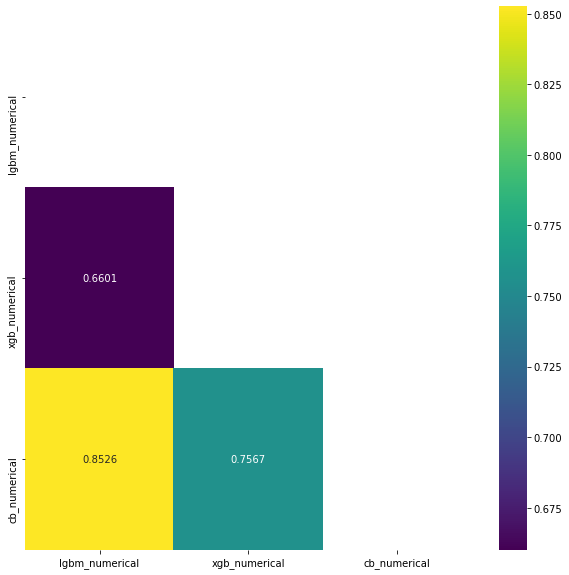

In [73]:
import seaborn as sns

# scores = pd.DataFrame({
#     'lgbm_numerical': model_lgb.predict(x_train[numerical_features]),
#     'xgb_numerical': xgb_model.predict(x_train[numerical_features]),
#     'cb_numerical': cb_model.predict(x_train[numerical_features])
# })

# scores = pd.DataFrame({
#     'lgbm_numerical': model_lgb.predict(train_df[numerical_features]),
#     'xgb_numerical': xgb_model.predict(train_df[numerical_features]),
#     'cb_numerical': cb_model.predict(train_df[numerical_features])
# })

scores = pd.DataFrame({
    'lgbm_numerical': y_pred_train_lgb,
    'xgb_numerical': y_pred_train_xgb,
    'cb_numerical': y_pred_train_cb
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4f", cmap="viridis", ax=axes)

__Корреляция на тестовой выборке__

<AxesSubplot:>

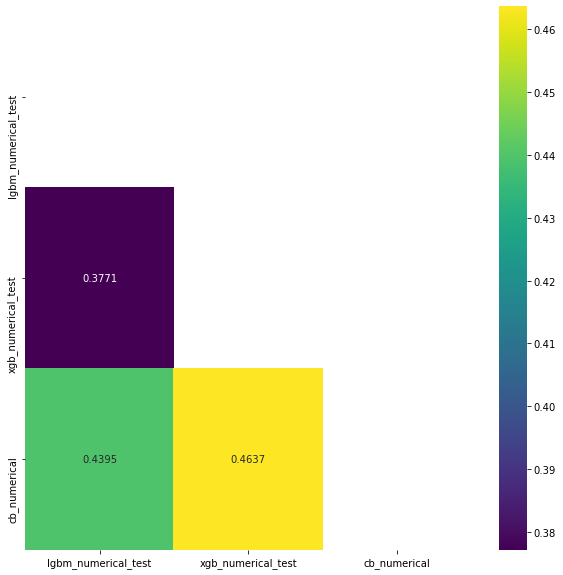

In [74]:
scores = pd.DataFrame({
    'lgbm_numerical_test': y_pred_lgb,
    'xgb_numerical_test': y_pred_xgb,
    'cb_numerical': y_pred_cb
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4f", cmap="viridis", ax=axes)

In [75]:
scores = pd.DataFrame({
    'lgbm_numerical': y_pred_train_lgb,
    'xgb_numerical': y_pred_train_xgb,
    'cb_numerical': y_pred_train_cb
})

__AMean__

In [76]:
# y = train_df['TARGET']
scores_mean = scores.mean(axis=1)
# score = roc_auc_score(y_train, scores_mean)
score = roc_auc_score(y, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.8665


__GMean__

In [78]:
#scores_meean = scores.gmean(axis=1)
scores_mean = gmean(scores, axis=1)
# score = roc_auc_score(target, scores_mean)
#score = roc_auc_score(y_train, scores_mean)
score = roc_auc_score(y, scores_mean)
print(f"Score = {round(score, 4)}")

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:402: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


Score = 0.6663


__Rankdata__

In [79]:
scores_mean = scores.rank().mean(axis=1)
#score = roc_auc_score(y_train, scores_mean)
score = roc_auc_score(y, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.8665


In [80]:
scores_mean = gmean(scores.rank(), axis=1)
#score = roc_auc_score(y_train, scores_mean)
score = roc_auc_score(y, scores_mean)
#score_meean = scores.rank().gmean(axis=1)
print(f"Score = {round(score, 4)}")

Score = 0.8665


## Задание 4:<a class="anchor" id="task4"></a>

(опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

## Задание 5:<a class="anchor" id="task5"></a>

(опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.